In [2]:
import os
import json
from pathlib import Path
from inspect import signature

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr, spearmanr, linregress
from scipy.signal import butter,filtfilt
from scipy.optimize import curve_fit

from utils.utils import get_slice
from annotation.annotations_io import load_annotations

In [3]:
def load_numpy_table(path, file_name='traces.npy'):
    return np.load(os.path.join(path, file_name))

def scatter_plot(x, y):
    plt.scatter(x, y)
    plt.show()
    
def line_plot(x):
    plt.figure(figsize=(15, 4.4))
    if x.ndim > 1:
        for x_i in x:
            plt.plot(np.arange(x_i.shape[0]), x_i)
    else:
        plt.plot(np.arange(x.shape[0]), x)
    plt.show()


def find_high_lut(fitted_curve, signal):
    multiplier = 0.0
    while(any(x<0 for x in fitted_curve * multiplier - signal)):
        multiplier += 0.01
    return fitted_curve * multiplier

def debleach(signal, curve_function, params):
    times = np.arange(signal.shape[0])
    high = find_high_lut(curve_function(times, *params), signal)
    return signal / high

def remove_nans(signal):
    temp = signal.copy()
    nans = ~np.isnan(temp)
    nans_idx = np.where(nans==False)[0]
    for idx in nans_idx:
        to_replace_idx = idx - 1
        while(temp[to_replace_idx]==np.NaN):
            to_replace_idx =- 1
        temp[idx] = temp[to_replace_idx]
    return temp, nans_idx

def insert_nans(signal, nans_idx):
    temp = signal.copy()
    for idx in nans_idx:
        temp[idx] = np.NaN
    return temp

def linear_interpolation(signal, idx1, idx2):
    temp = signal.copy()
    slope = (signal[idx2] - signal[idx1]) / (idx2 - idx1)
    for t in range(idx1, idx2):
        temp[t] = slope * (t - idx1) + signal[idx1]
    return temp


def reversal_indices(path):
    reversal_indices_file = open(path / 'reversal_indices.txt', 'r')
    return np.array([int(t.strip()) for t in reversal_indices_file.readlines()])

In [5]:
paths = [Path(r'C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_1\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_3\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_4\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_2\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_3\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_7\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_8\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_10\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_3\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_5\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_8\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_2\run_1\centered'),
         Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_6\run_1\centered')]

In [7]:
for path in paths:
    debleached_traces = load_numpy_table(path, 'debleached_traces.npy')
    reversal_idx = reversal_indices(path)
    n_reversals = reversal_idx.shape[0]
    n_channels, n_neurons, n_timepoints = debleached_traces.shape
    reversal_traces = np.zeros((n_channels, 4, n_reversals, 80))
    reversal_traces[:] = np.NaN
    for c in range(n_channels):
        for n in range(n_neurons):
            for idx, rev_t in enumerate(reversal_idx):
                if path == Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_10\run_1\centered'):
                    rev_t = rev_t - 30
                if path == Path(r'C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_5\run_1\centered'):
                    rev_t = rev_t - 250
                reversal_traces[c, n, idx, :] = debleached_traces[c, n, rev_t-20:rev_t+60]
    np.save(path / "reversal_traces.npy", reversal_traces)

In [10]:
def get_sorted_reversal_traces(paths):
    sorted_by_name = []
    for path in paths:
        _, W = load_annotations(path)
        reversal_traces = load_numpy_table(path, 'reversal_traces.npy')
        n_channels, n_neurons, n_reversals, n_timepoints = reversal_traces.shape
        names = [b'RIML', b'RIMR', b'RIMLU', b'RIMRU']
            
        for n in range(n_reversals):
            temp = np.zeros((4, n_timepoints))
            temp[:] = np.NaN
            for idx, name in enumerate(names):
                if W.df[W.df["name"] == name]["id"].shape[0] == 1:
                    temp[idx, :] = reversal_traces[1, W.df[W.df["name"] == name]["id"].item(), n, :]
            sorted_by_name.append(temp)
    return np.array(sorted_by_name)
sorted_reversal_traces = get_sorted_reversal_traces(paths)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


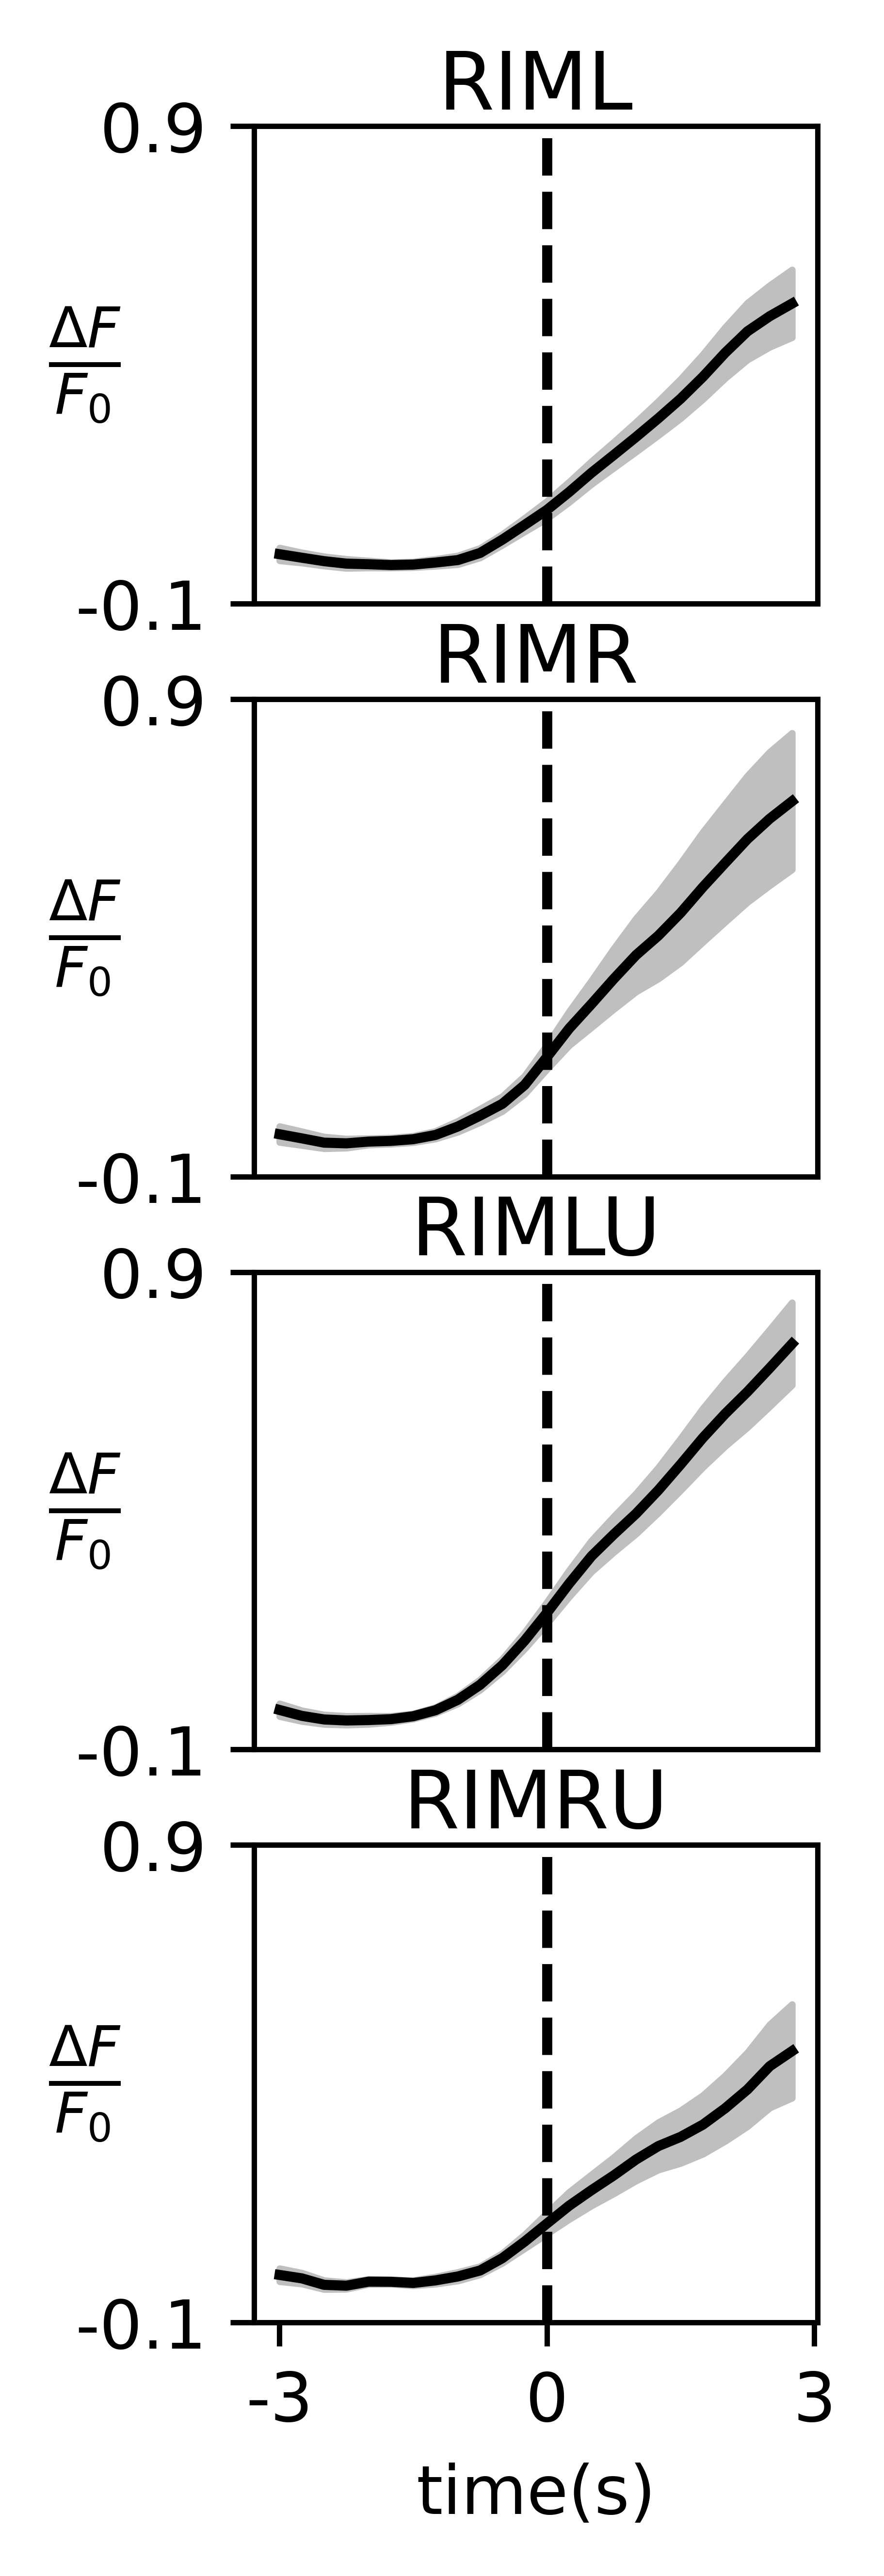

In [11]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def plot_reversal_traces(all_traces, names):
    plt.figure(figsize=(1.5, 1.5 * all_traces.shape[1]), dpi=1000)
    
    n_traces, n_neurons, n_timepoints = all_traces.shape
   
 
    for i in range(n_neurons):
        
        plt.subplot(n_neurons, 1, i+1)
        plt.ylabel(r'$\frac{\Delta F}{F_0}$', rotation=0, weight='bold', horizontalalignment='left', fontsize=12, verticalalignment='center' )
        plt.gca().set_title(names[i].decode(), verticalalignment='top')
        plt.xticks([])
        
        zoomedin_traces = np.zeros((n_traces, n_neurons, 24))
        for j, trace in enumerate(all_traces[:, i, :]):
            baseline = np.nanmean(trace[8:20])
            zoomedin_traces[j, i, :] = (trace[8:32] - baseline) / baseline  

        avg = np.nanmean(zoomedin_traces[:, i, :], axis=0)
        std = np.nanstd(zoomedin_traces[:, i, :], axis=0) / np.sqrt(n_traces - 1)
        
        ylim1 = 0.9 
        ylim0 = -0.1
        
        plt.ylim(ylim0, ylim1)
        plt.yticks([ylim0, ylim1], [ylim0, ylim1])
        
        plt.plot(np.arange(24), avg, "black", linewidth = "1.5")
        plt.fill_between(np.arange(24), avg+std, avg-std, color="#bfbfbf")
        plt.vlines(12, ylim0, ylim1,  linestyles='dashed')
    plt.xticks([0, 12, 24], [-3, 0, 3])
    
    plt.xlabel("time(s)")
    plt.savefig(Path(r"C:\Users\Mahdi\Desktop\XE2551\averaged_reversal_traces.pdf"), 
                bbox_inches = "tight", pad_inches = 0.5, transparent=True)
    plt.show()
plot_reversal_traces(sorted_reversal_traces, [b'RIML', b'RIMR', b'RIMLU', b'RIMRU'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


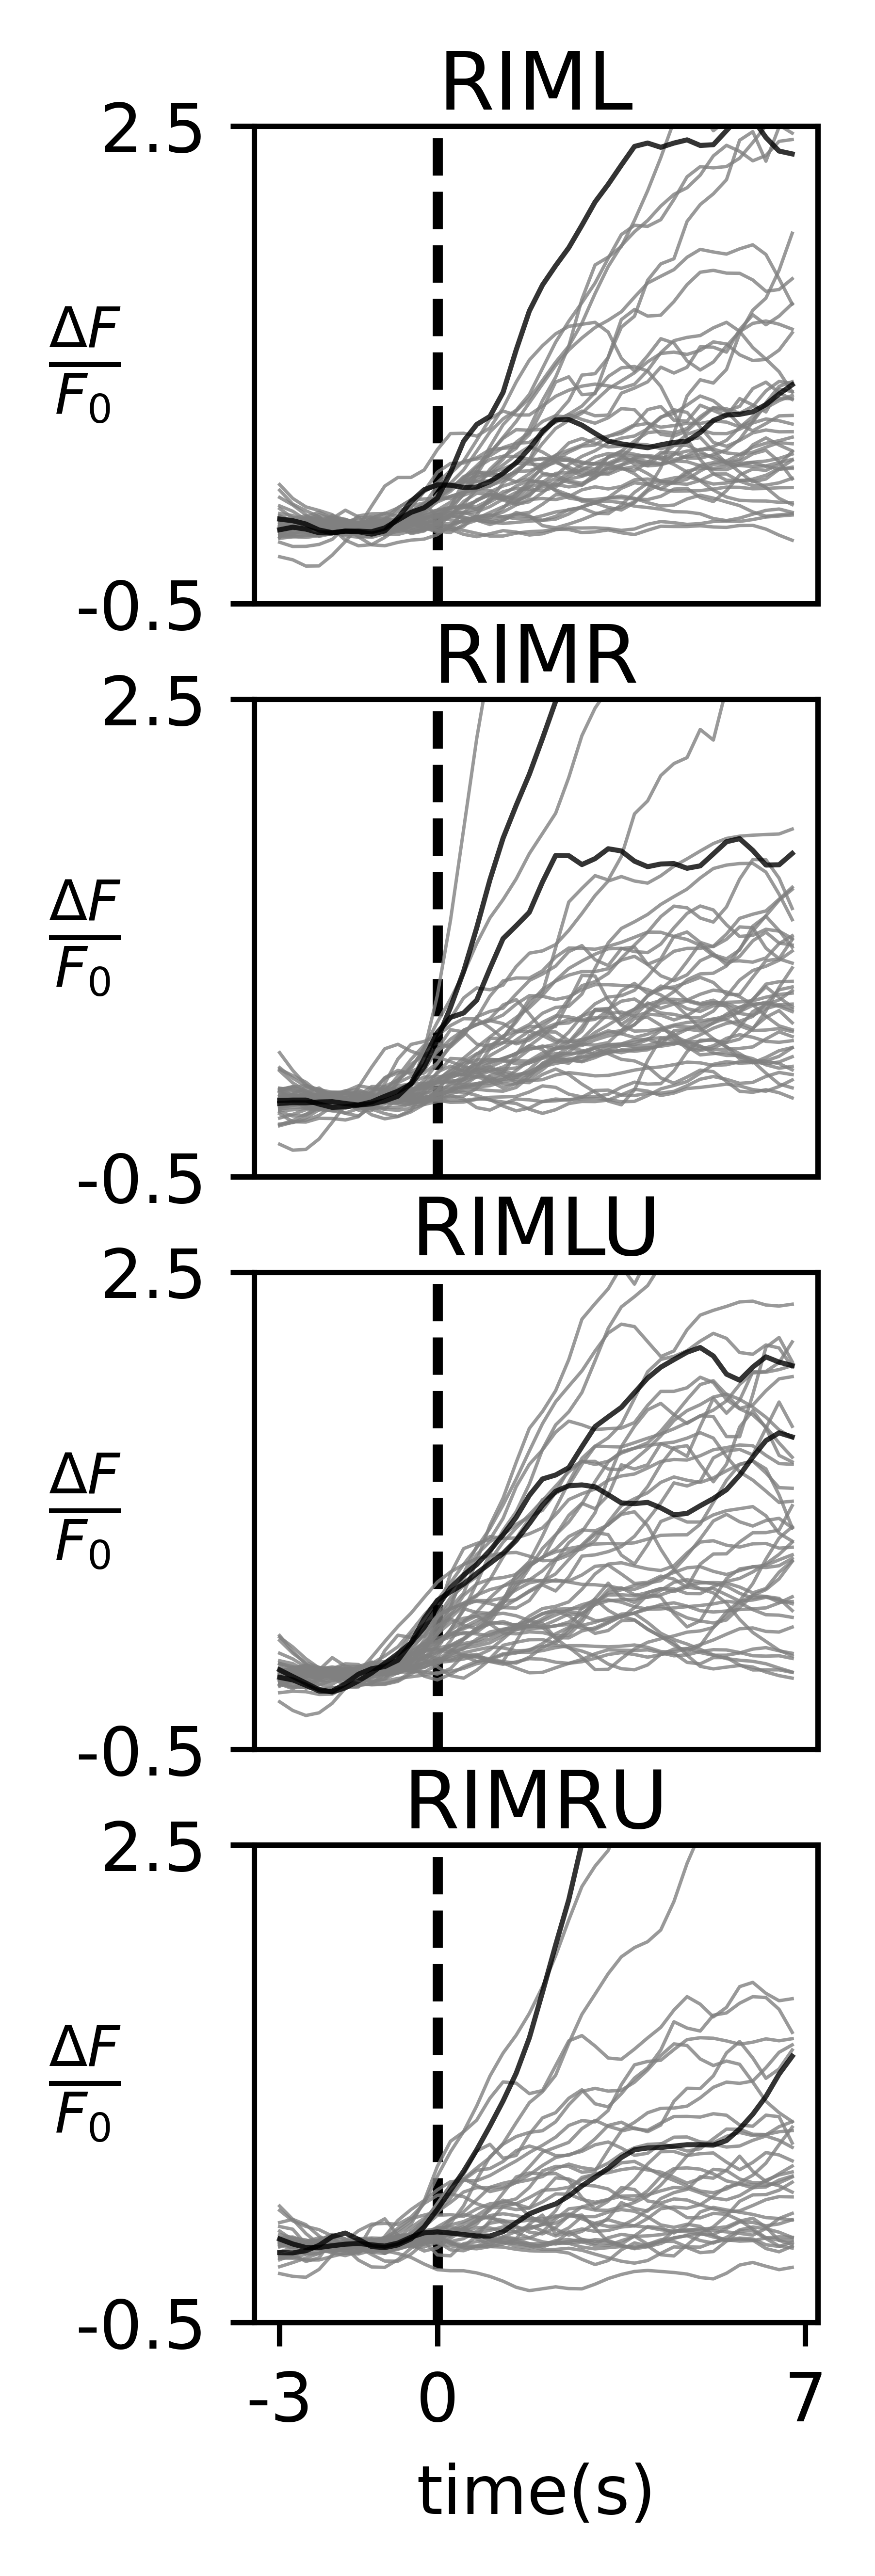

In [61]:
def plot_reversal_traces_spaghetti(all_traces, names):
    plt.figure(figsize=(1.5, 1.5 * all_traces.shape[1]), dpi=1000)
    
    n_traces, n_neurons, n_timepoints = all_traces.shape
   
 
    for i in range(n_neurons):
        
        plt.subplot(n_neurons, 1, i+1)
        plt.ylabel(r'$\frac{\Delta F}{F_0}$', rotation=0, weight='bold', horizontalalignment='left', fontsize=12, verticalalignment='center' )
        plt.gca().set_title(names[i].decode(), verticalalignment='top')
        plt.xticks([])
        
#         zoomedin_traces = np.zeros((n_traces, n_neurons, 24))
        zoomedin_traces = np.zeros((n_traces, n_neurons, 40))
        for j, trace in enumerate(all_traces[:, i, :]):
            baseline = np.nanmean(trace[8:20])
            zoomedin_traces[j, i, :] = (trace[8:48] - baseline) / baseline
            if j==20 or j==21:
        
                plt.plot(np.arange(40), zoomedin_traces[j, i, :], "black", linewidth = "0.75", alpha=0.8, zorder=3)
            else:
                plt.plot(np.arange(40), zoomedin_traces[j, i, :], "gray", linewidth = "0.5", alpha=0.8, zorder=2)
        
        ylim1 = 2.5 
        ylim0 = -0.5
        
        plt.ylim(ylim0, ylim1)
        plt.yticks([ylim0, ylim1], [ylim0, ylim1])
        
        plt.vlines(12, ylim0, ylim1,  linestyles='dashed', zorder=1)
    plt.xticks([0, 12, 40], [-3, 0, 7])
    
    plt.xlabel("time(s)")
    plt.savefig(Path(r"C:\Users\Mahdi\Desktop\XE2551\averaged_reversal_traces_spaghetti.pdf"), 
                bbox_inches = "tight", pad_inches = 0.5, transparent=True)
    plt.show()
plot_reversal_traces_spaghetti(sorted_reversal_traces, [b'RIML', b'RIMR', b'RIMLU', b'RIMRU'])

In [39]:
trace_list = []
reversal_t_list = []
all_names = []
y_ticks = []
for path in paths:
    _, W = load_annotations(path)
    names = [W.df[W.df['id']==i]['name'].item().decode() for i in range(len(W))]
    y_ticks.append(len(W))
    w_ids = list(range(len(W)))
    sorted_names = sorted(names)
    all_names.append(sorted_names)
    sorted_ids = [w_ids[names.index(name)] for name in sorted_names]
    trace = load_numpy_table(path, 'debleached_traces.npy')[1, :, :840]
    sorted_trace = trace[sorted_ids ,:]
    trace_list.append(sorted_trace)
    if path == Path(r'C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_10\run_1\centered'):
        reversal_t_list.append(reversal_indices(path) - 30)
    elif path == Path(r'C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_5\run_1\centered'):
        reversal_t_list.append(reversal_indices(path) - 250)
    else:
        reversal_t_list.append(reversal_indices(path))
        
concat_traces = np.concatenate(trace_list, axis=0)
    
y_ticks_sum = np.cumsum(y_ticks)

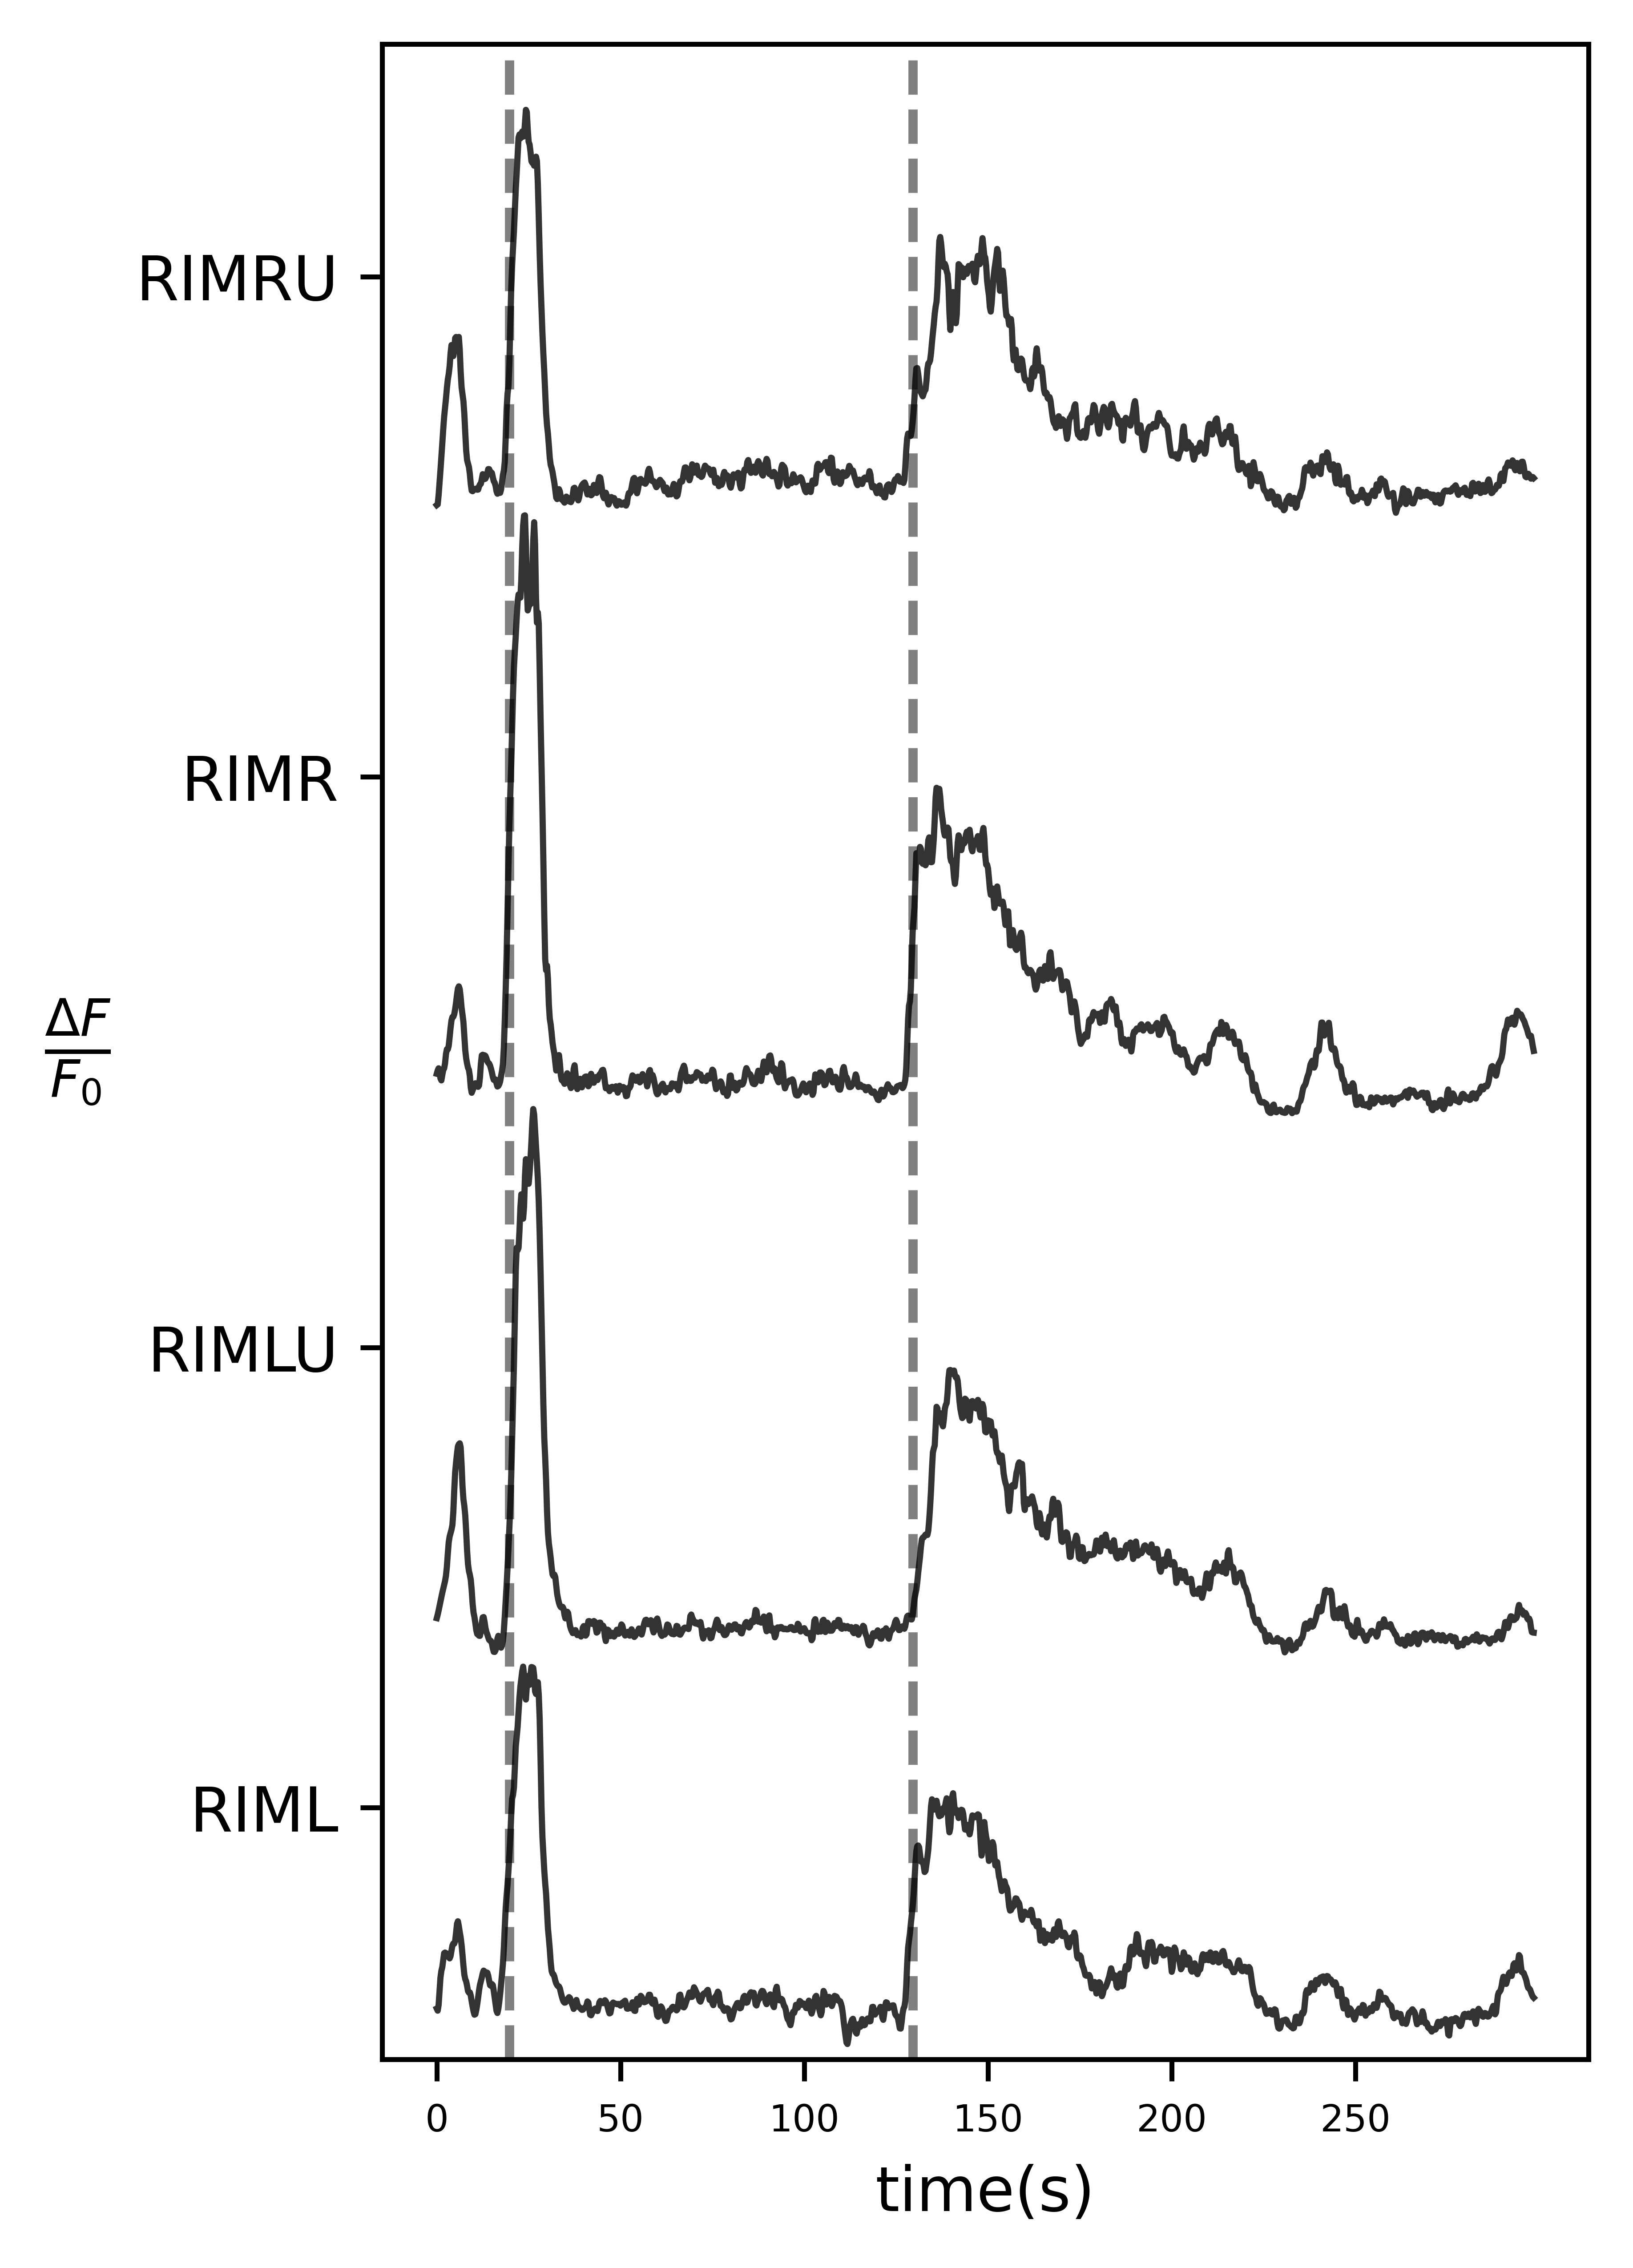

In [71]:
def plot_example_trace(p):
    debleached_traces = load_numpy_table(p, 'debleached_traces.npy')[:, :, 5:]
    
    _, W = load_annotations(p)
    names = [W.df[W.df['id']==i]['name'].item().decode() for i in range(len(W))]
    
    w_ids = list(range(len(W)))
    sorted_names = sorted(names)
    sorted_ids = [w_ids[names.index(name)] for name in sorted_names]
    sorted_trace = debleached_traces[:, sorted_ids ,:]
    colors = ['#E74C3C', '#17A589', '#2980B9', '#E67E22']
    
    plt.figure(figsize=(3.5, 1.5 * 4), dpi=1000)
    
    n_timepoints = debleached_traces.shape[-1]
   
    offset = 0.0
    y_top = 0.0
    y_bot = 0.0
    label_location = []
    for i in range(4):
        
        bl = np.nanmean(debleached_traces[1, i, 800:])
        trace = (debleached_traces[1, i, :] - bl) / bl
        if i==0:
            y_bot = np.nanmin(trace) - 0.1
            
        
        
        trace = trace + offset
        label_location.append(offset + (np.nanmax(trace) - np.nanmin(trace)) / 2)
        offset = offset + (np.nanmax(trace) - np.nanmin(trace)) / 1
        y_top = y_top + (np.nanmax(trace) - np.nanmin(trace)) / 1
        plt.plot(np.arange(n_timepoints), trace, "black", linewidth = "1.0", alpha=0.8, label=sorted_names[i])
        
        plt.ylabel(r'$\frac{\Delta F}{F_0}$', rotation=0, weight='bold',
                   horizontalalignment='right', fontsize=12, verticalalignment='center' )
        
        plt.xticks([])
        plt.yticks([])
        
#     plt.legend()
    bottom, top = plt.ylim()
    plt.ylim((y_bot, y_top + 0.2))
        
        
    plt.yticks(label_location, sorted_names)
    plt.vlines(reversal_t_list[8], y_bot, y_top + 1.6, linestyles='dashed',  color='gray',zorder=1)
        
    
    plt.xlabel("time(s)")
    plt.xticks(np.arange(0, n_timepoints, 200), np.arange(0, n_timepoints//4, 50), fontsize = 6)
    plt.savefig(Path(r"C:\Users\Mahdi\Desktop\XE2551\trace_for_animal_11.pdf"), 
                bbox_inches = "tight", pad_inches = 0.5, transparent=True)
    plt.show()
plot_example_trace(paths[8])

In [72]:
for path in paths:
    print(path)
    debleached_traces = load_numpy_table(path, 'debleached_traces.npy')
    nan_removed_traces = np.zeros_like(debleached_traces)
    for i, trace in enumerate(debleached_traces[1,:,:]):
        temp, _ = remove_nans(trace)
        nan_removed_traces[1, i, :] = temp
    c = np.corrcoef(nan_removed_traces[1,:,:])
    np.save(path / "corrcoef.npy", c)

C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_1\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_3\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_4\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_2\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_3\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_7\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_8\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_10\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_3\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_5\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\12_14_2020\animal_8\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_22_2021\animal_2\run_1\centered
C:\Users\Mahdi\Desktop\XE2551\01_30_2021\animal_6\run_1\centered


In [74]:
LR = []
URR = []
ULL = []
for path in paths:
    corrcoef_matrix = load_numpy_table(path, 'corrcoef.npy')
    _, W = load_annotations(path)
    

    
    r_idx = W.df[W.df["name"] == b'RIMR']["id"].item()
    l_idx = W.df[W.df["name"] == b'RIML']["id"].item()
    ul_idx = W.df[W.df["name"] == b'RIMLU']["id"].item()
    if W.df[W.df["name"] == b'RIMRU']["id"].shape[0] == 1:
        ur_idx = W.df[W.df["name"] == b'RIMRU']["id"].item()
        LR.append(corrcoef_matrix[ur_idx, ul_idx])
        URR.append(corrcoef_matrix[r_idx, ur_idx])
        
    LR.append(corrcoef_matrix[r_idx, l_idx])
    ULL.append(corrcoef_matrix[l_idx, ul_idx])
    
c_list = [LR, URR, ULL]
avg_list = [np.mean(i) for i in c_list]
sem_list = [np.std(i) / np.sqrt(len(i) - 1) for i in c_list]
n_list = [len(i) for i in c_list]

from scipy import stats
LR_URR = stats.ttest_ind(LR,URR)
LR_ULL = stats.ttest_ind(LR,ULL)
URR_ULL = stats.ttest_ind(URR,ULL)

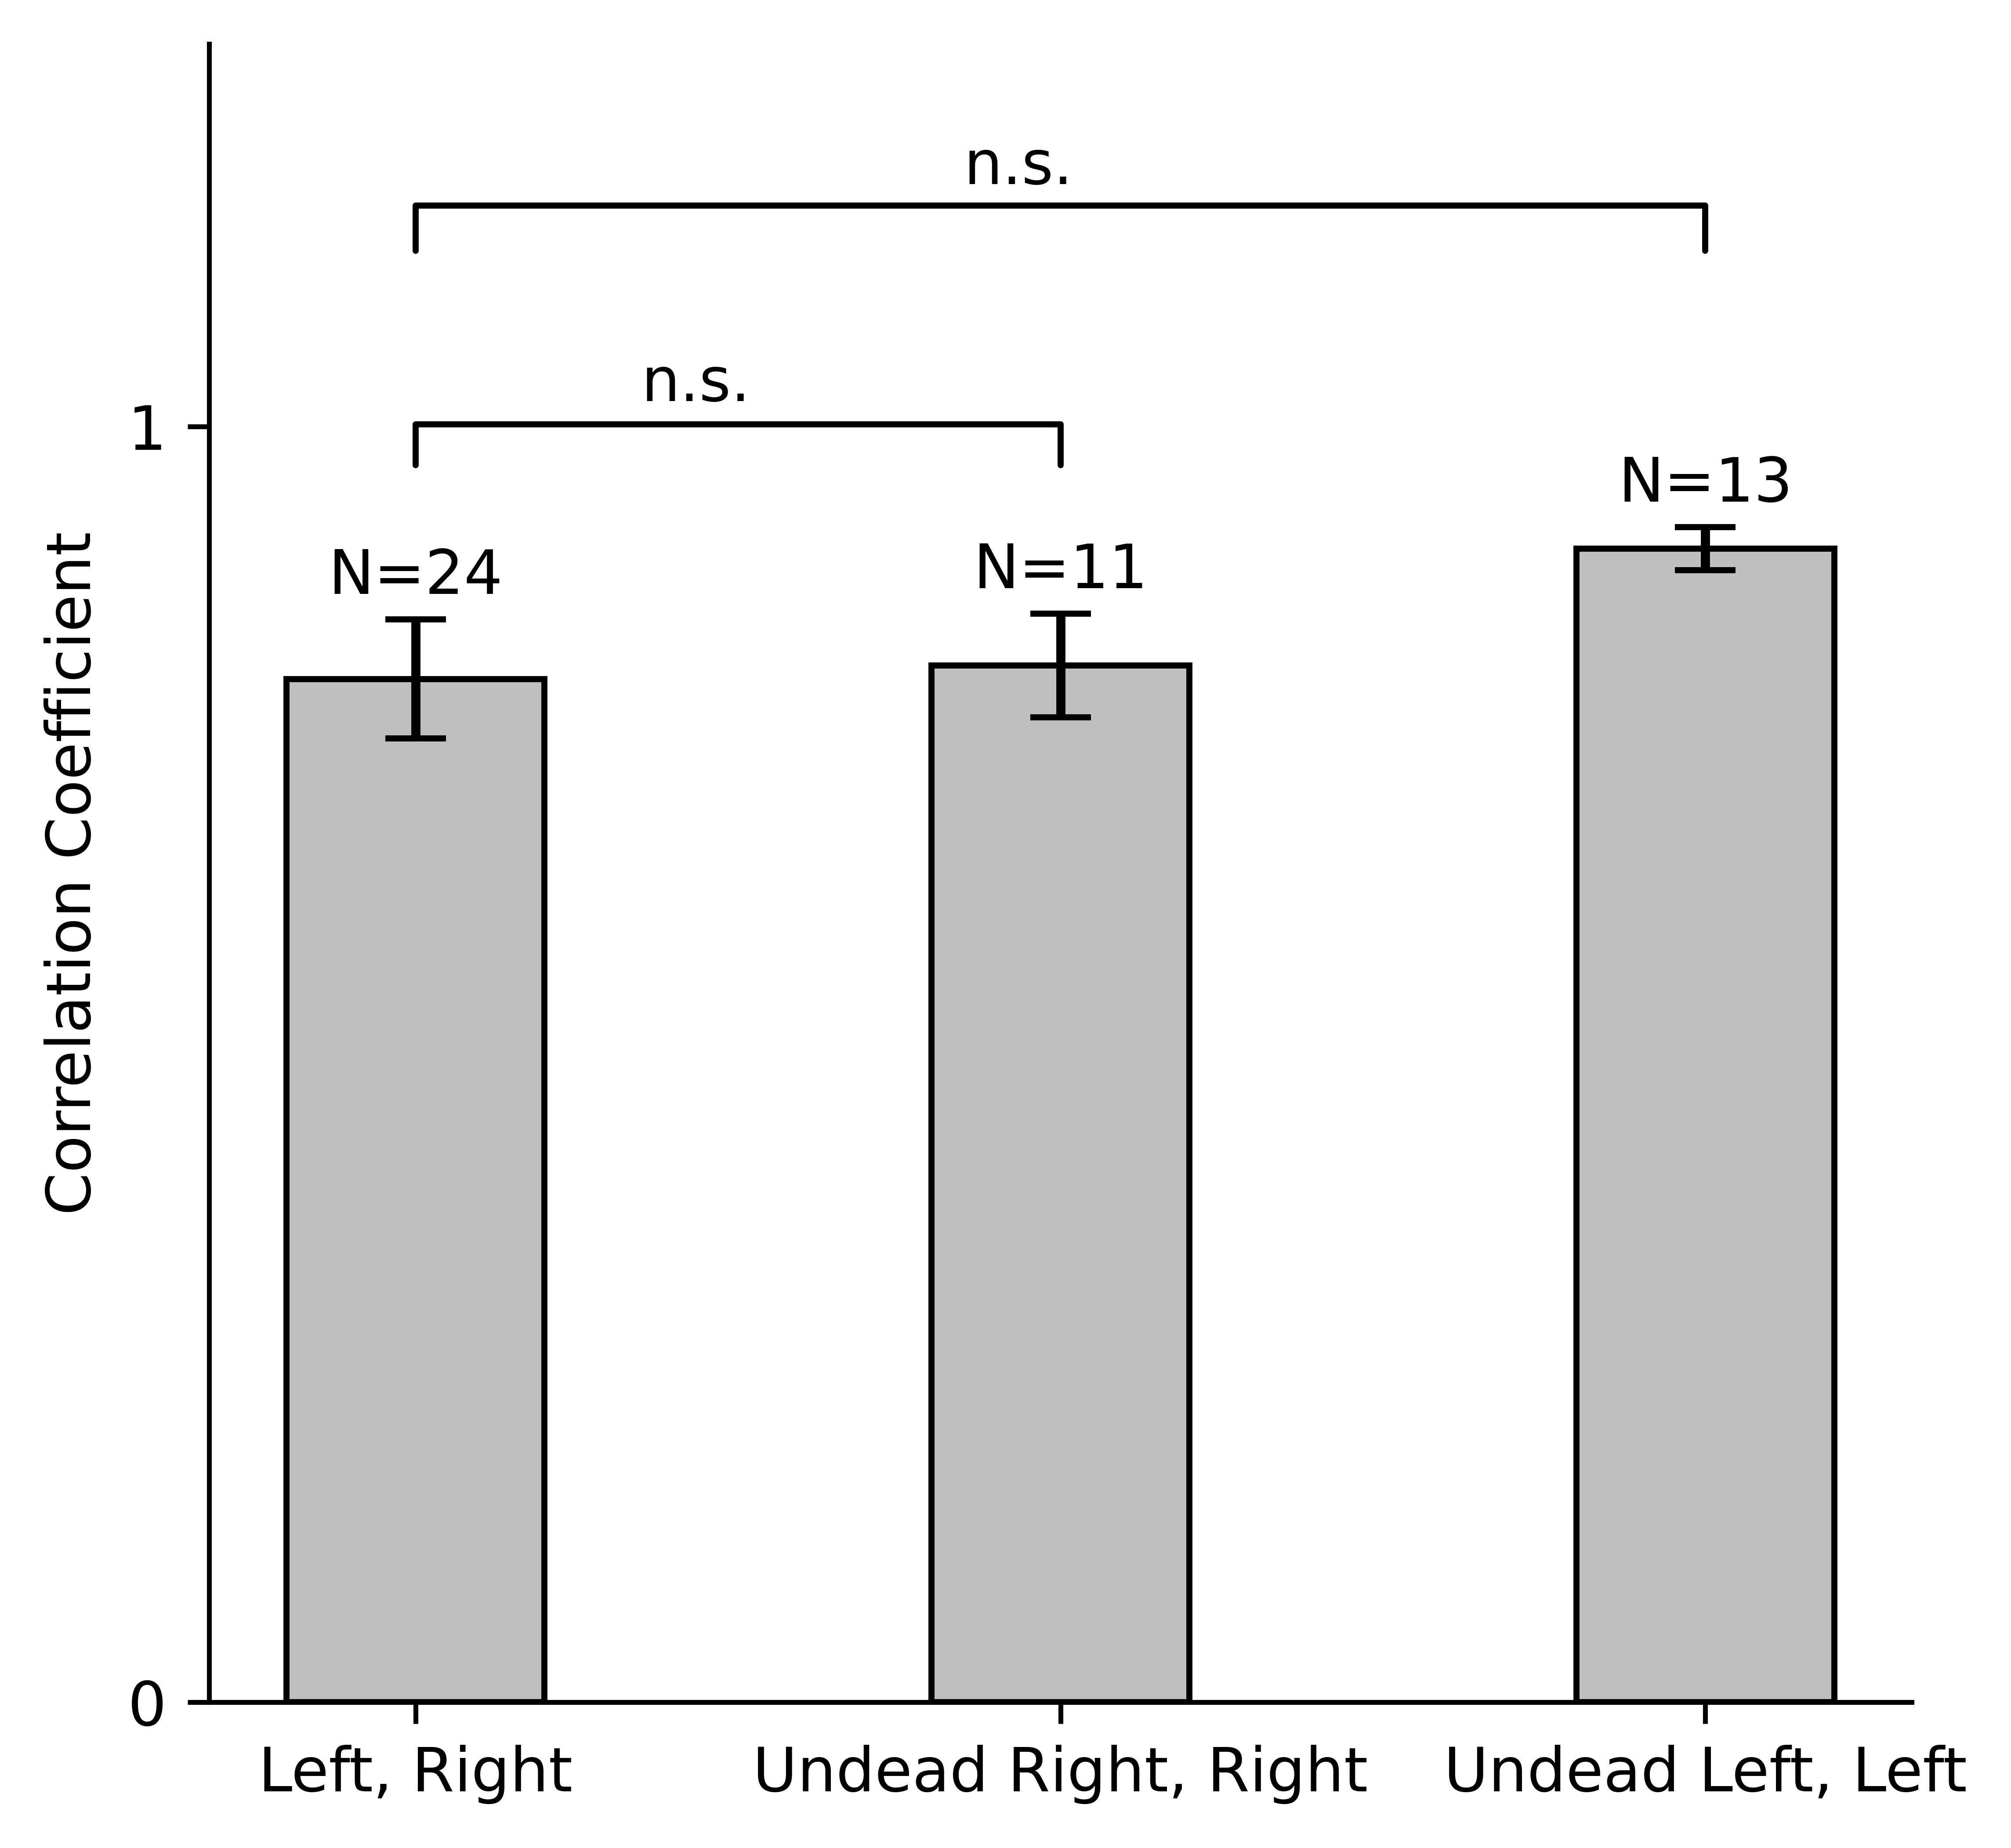

In [91]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=1000)
plt.bar(np.arange(3), avg_list, yerr=sem_list,capsize=5, width=0.4, color="#bfbfbf",
        edgecolor='black', linewidth=1, bottom=None,  align='center')
plt.ylim(0.0, 1.3)
plt.ylabel("Correlation Coefficient")
plt.yticks([0, 1], [0, 1])
plt.xticks(np.arange(3), ['Left, Right', 'Undead Right, Right', 'Undead Left, Left'])
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
for i, n in enumerate(n_list):
    plt.text(i, avg_list[i] + sem_list[i] + 0.02, 'N=' + str(n), ha='center')
    
    


props = {'connectionstyle':'bar','arrowstyle':'-', 'shrinkA':25,'shrinkB':25,'linewidth':1}


ax.annotate('n.s.', xy=(0.35, 0.85 + 0.17), zorder=10)
ax.annotate('', xy=(0, 0.85), xytext=(1, 0.85), arrowprops=props)
    

# ax.annotate('p={}'.format(round(URR_ULL[1],2)), xy=(1.3, 0.93 + 0.17), zorder=10)
# ax.annotate('', xy=(1, 0.93), xytext=(2, 0.93), arrowprops=props)


props = {'connectionstyle':'bar','arrowstyle':'-', 'shrinkA':56,'shrinkB':56,'linewidth':1}

ax.annotate('n.s.'.format(round(LR_ULL[1],2)), xy=(.85, 1.02 + 0.17), zorder=10)
ax.annotate('', xy=(0, 0.87), xytext=(2, 0.87), arrowprops=props)
    
    
    
    
    
    
    
plt.savefig(Path(r"C:\Users\Mahdi\Desktop\XE2551\correlation_coefficient.pdf"), 
            bbox_inches = "tight", pad_inches = 0.5, transparent=True)
plt.show()

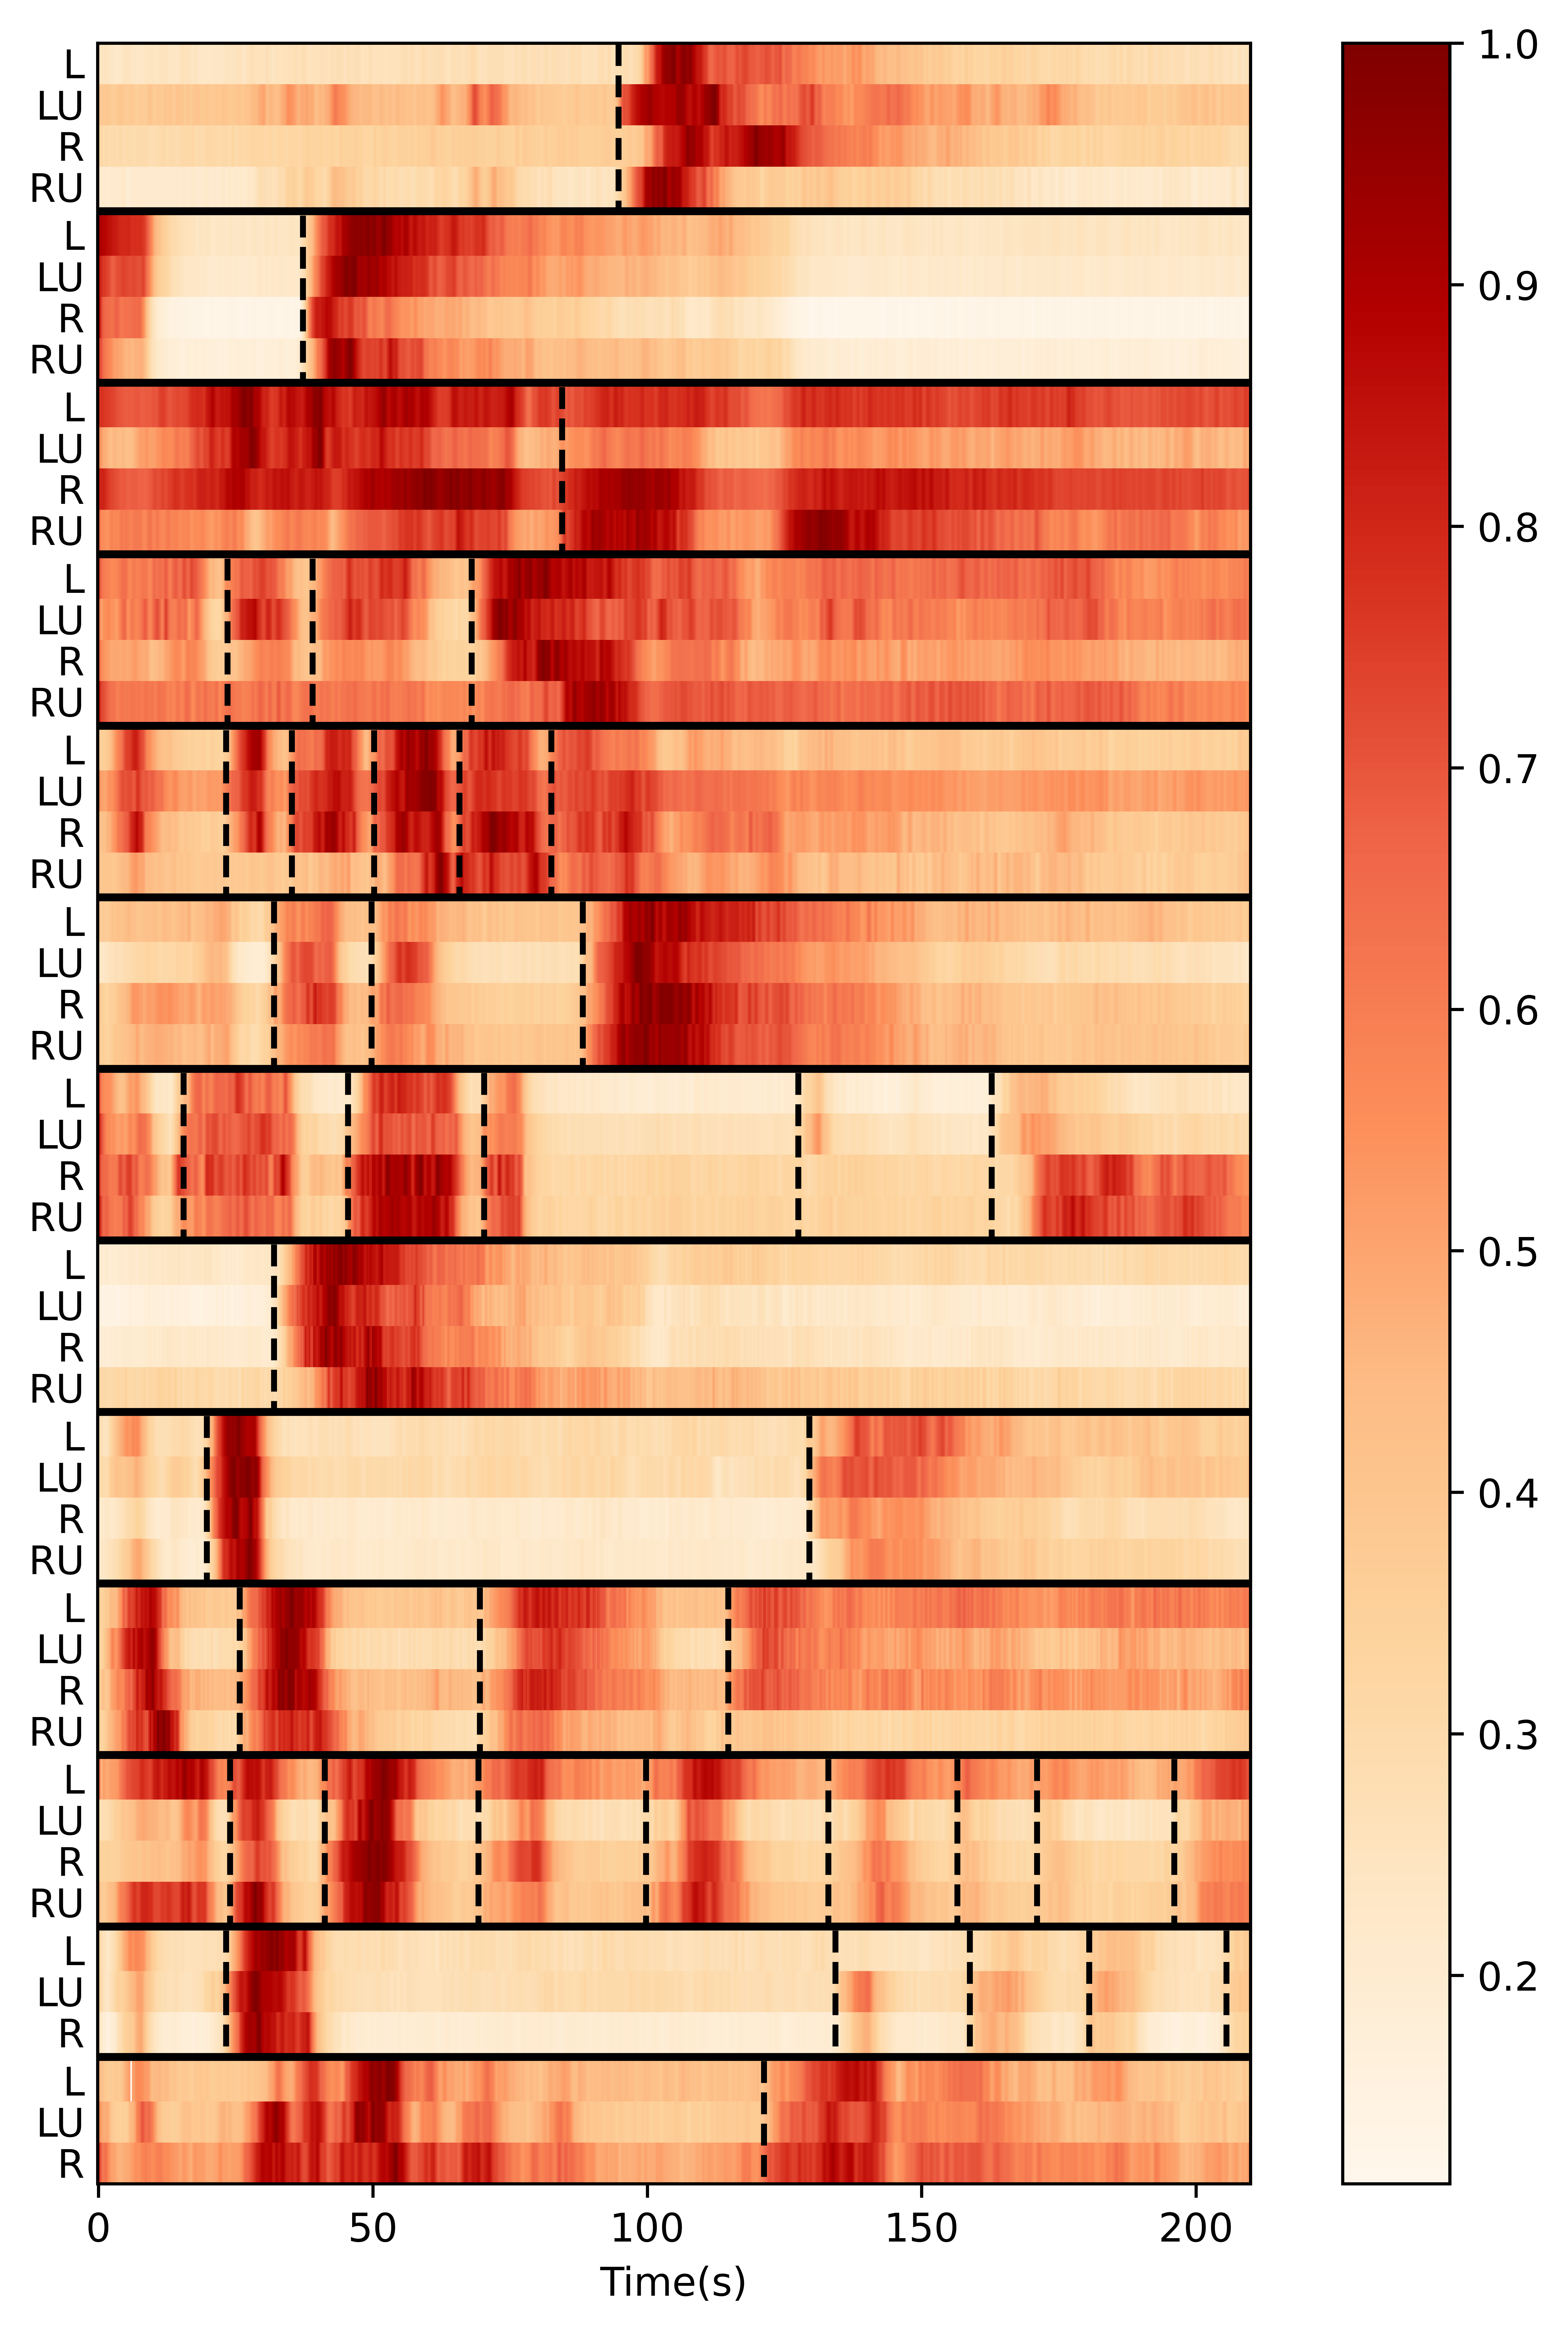

In [88]:
repeat = 30

fig, ax= plt.subplots(figsize=(concat_traces.shape[1] / 100,  2 * concat_traces.shape[0] / 10), dpi=1000)
x = np.zeros_like(concat_traces)
for i in range(concat_traces.shape[0]):
    x[i] = concat_traces[i, :] / np.nanmax(concat_traces[i, :])
repeated_traces = np.repeat(x, repeat, axis=0)
insert_row = np.ones((5, 840)) * 0.5
for i, idx in enumerate(y_ticks_sum):
    for j, neuron_name in enumerate(all_names[i]):
        plt.text(-10 , repeat * (idx  - len(all_names[i]) + 1) + j * 30 + 5 * (i - 1) , neuron_name[3:], ha='right')
    if i!=12:
        repeated_traces = np.insert(repeated_traces, repeat * idx + i*5 , insert_row, axis=0)
    
        plt.hlines(repeat * idx + i*5 + 2, 0, 840, color="black", linewidth=2, zorder=2)
    plt.vlines(reversal_t_list[i], repeat * idx + i*5 - repeat * y_ticks[i],  repeat * idx + i * 5, color='black', zorder=1, linestyle="dashed")
im = ax.imshow(repeated_traces, cmap='OrRd')
# cbar = fig.colorbar(im, ax=ax)

plt.yticks([])
plt.xticks(np.arange(0, 840, 200), np.arange(0, 840//4, 50 ), fontsize = 10)
plt.xlabel("Time(s)")
plt.colorbar(im, ax=ax)
plt.savefig(Path(r"C:\Users\Mahdi\Desktop\XE2551\heatmap.pdf"), 
            bbox_inches = "tight", pad_inches = 0.5, transparent=True)
plt.show()

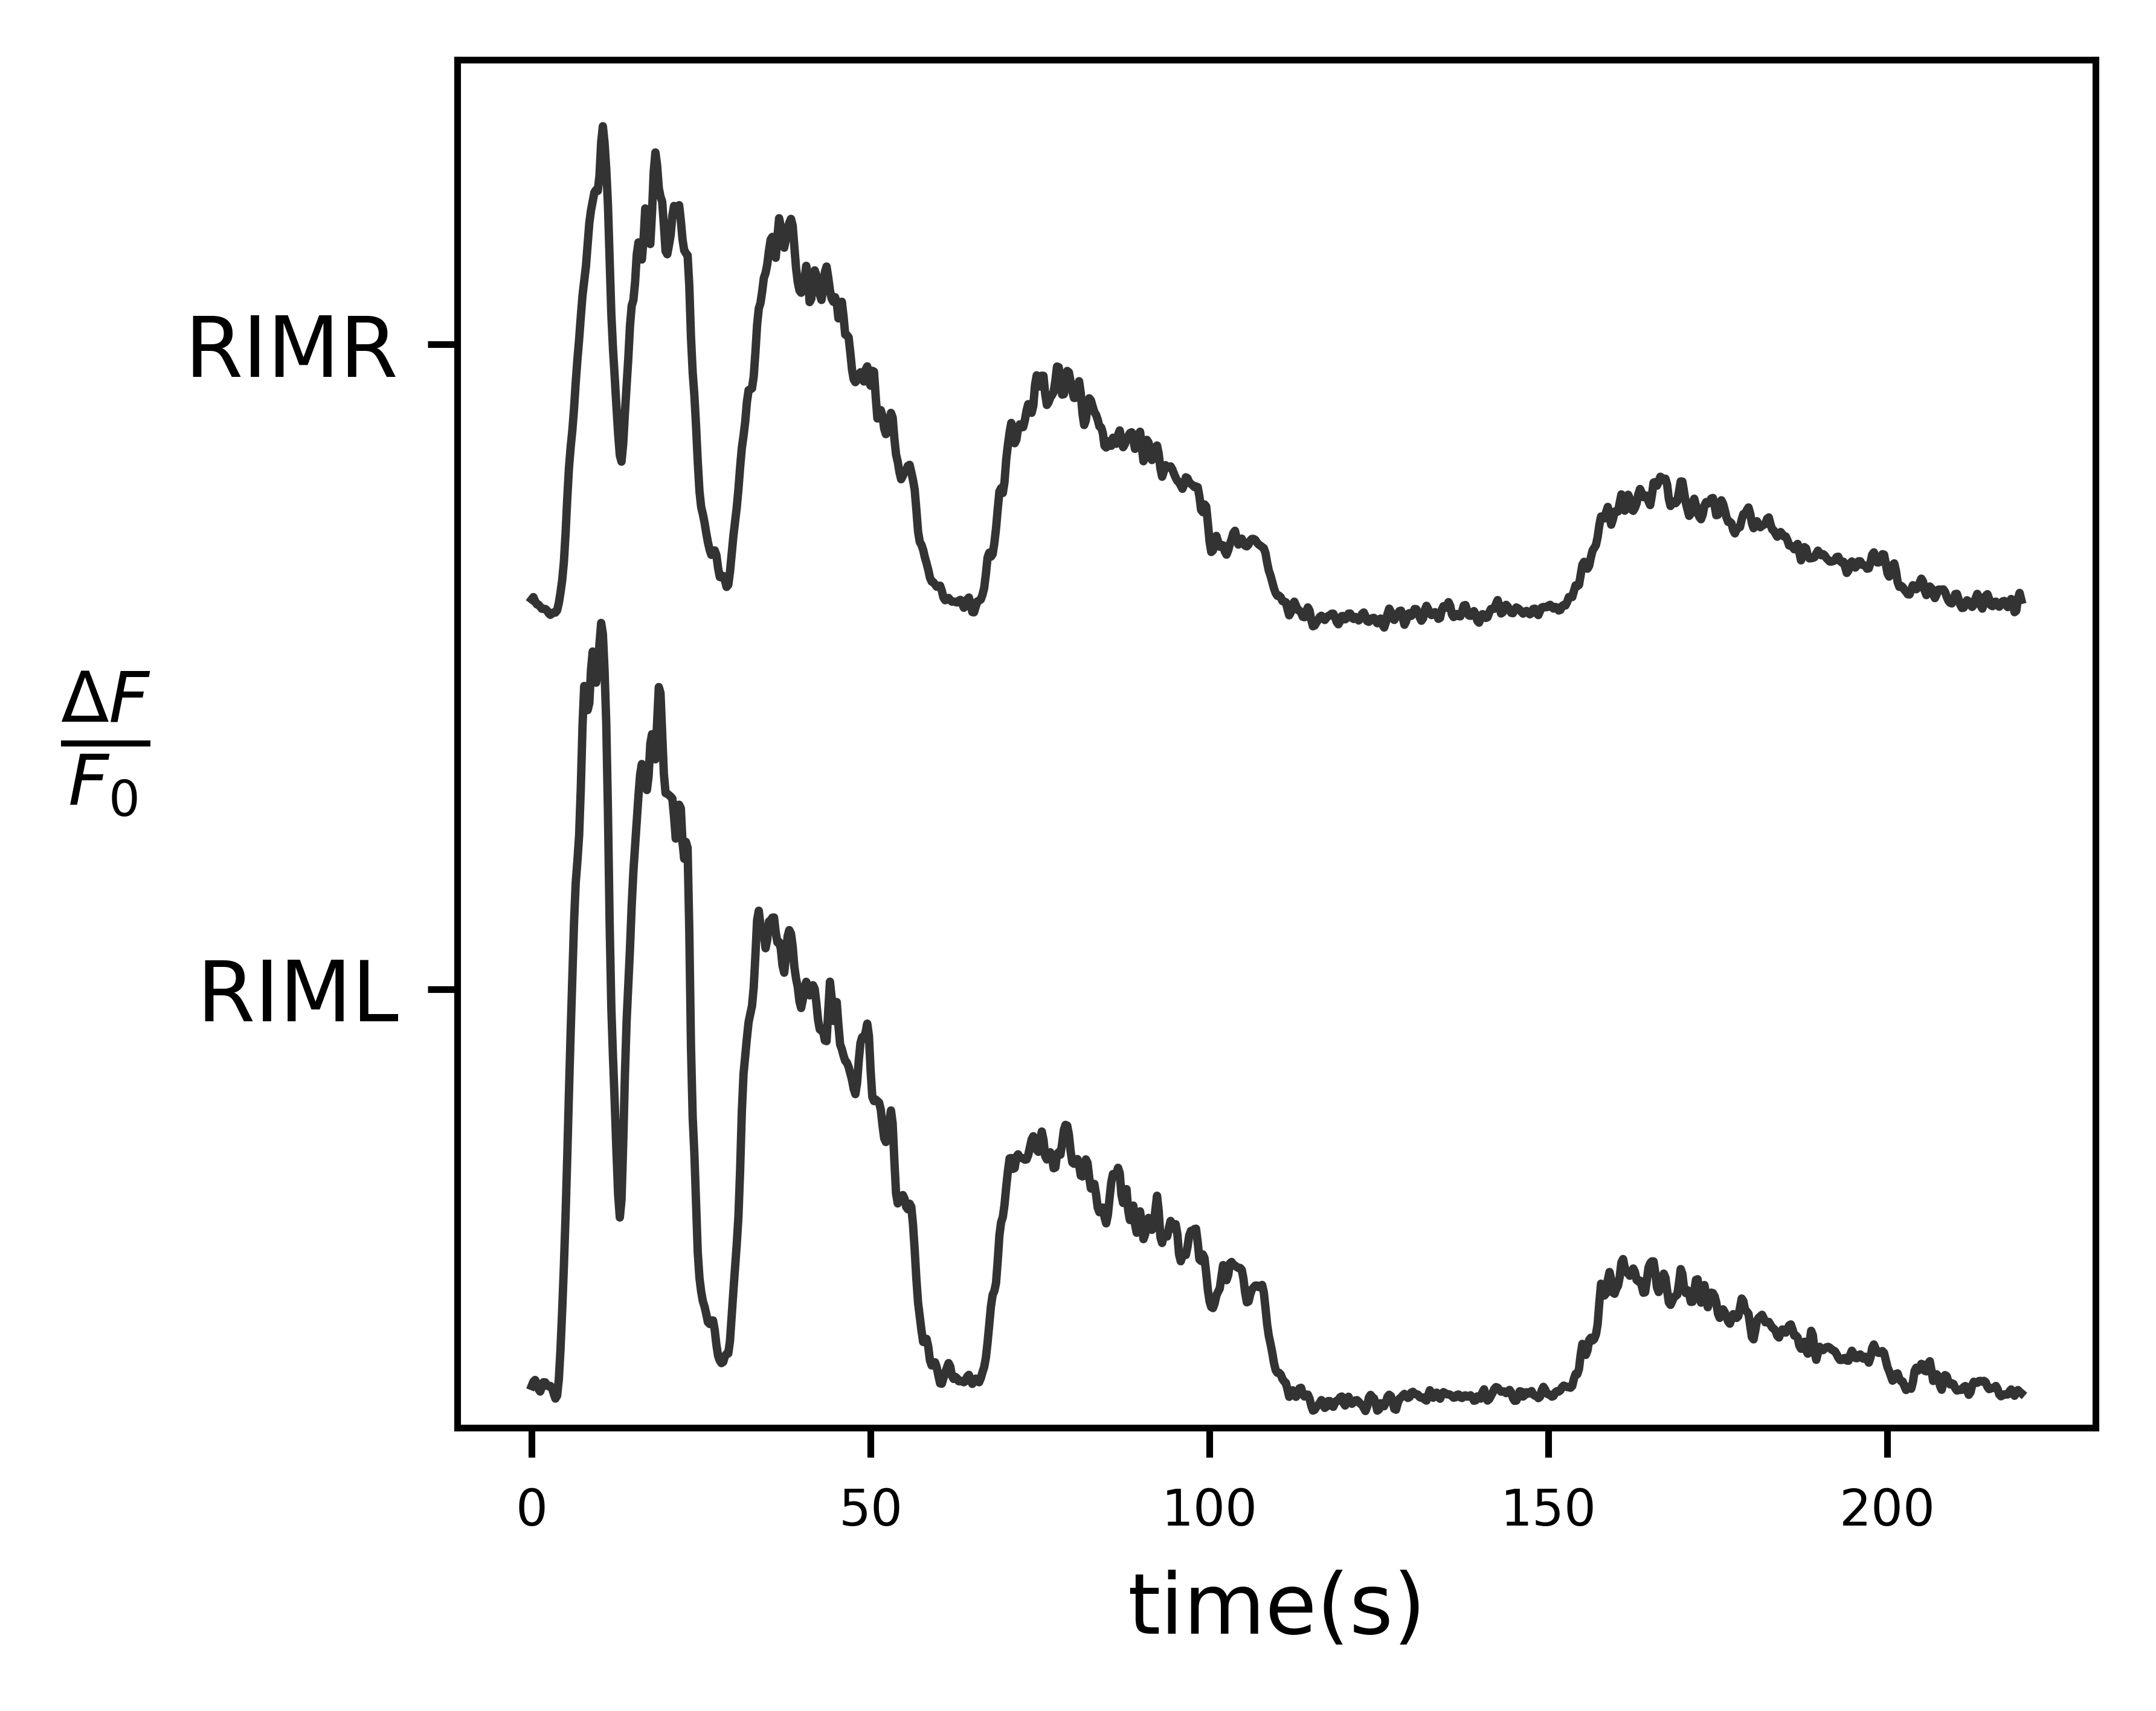

In [10]:
def plot_example_trace(p):
    debleached_traces = load_numpy_table(p, 'debleached_traces.npy')[:, :, 20:]
    
    _, W = load_annotations(p)
    names = [W.df[W.df['id']==i]['name'].item().decode() for i in range(len(W))]
    
    w_ids = list(range(len(W)))
    sorted_names = sorted(names)
    sorted_ids = [w_ids[names.index(name)] for name in sorted_names]
    sorted_trace = debleached_traces[:, sorted_ids ,:]
    colors = ['#E74C3C', '#17A589', '#2980B9', '#E67E22']
    
    plt.figure(figsize=(3.5, 1.5 * 2), dpi=1000)
    
    n_timepoints = debleached_traces.shape[-1]
   
    offset = 0.0
    y_top = 0.0
    y_bot = 0.0
    label_location = []
    for i in range(2):
        
        bl = np.nanmean(debleached_traces[1, i, 800:])
        trace = (debleached_traces[1, i, :] - bl) / bl
        if i==0:
            y_bot = np.nanmin(trace) - 0.1
            
        
        
        trace = trace + offset
        label_location.append(offset + (np.nanmax(trace) - np.nanmin(trace)) / 2)
        offset = offset + (np.nanmax(trace) - np.nanmin(trace)) / 1
        y_top = y_top + (np.nanmax(trace) - np.nanmin(trace)) / 1
        plt.plot(np.arange(n_timepoints), trace, "black", linewidth = "1.0", alpha=0.8, label=sorted_names[i])
        
        plt.ylabel(r'$\frac{\Delta F}{F_0}$', rotation=0, weight='bold',
                   horizontalalignment='right', fontsize=12, verticalalignment='center' )
        
        plt.xticks([])
        plt.yticks([])
        
#     plt.legend()
    bottom, top = plt.ylim()
    plt.ylim((y_bot, y_top + 0.2))
        
        
    plt.yticks(label_location, sorted_names)
#     plt.vlines([76- 20, 138 - 20, 289 - 20], y_bot, y_top + 1.6, linestyles='dashed',  color='gray',zorder=1)
        
    
    plt.xlabel("time(s)")
    plt.xticks(np.arange(0, n_timepoints, 200), np.arange(0, n_timepoints//4, 50), fontsize = 6)
    plt.savefig(os.path.join(p, "trace_for_control_animal_no_reverse_time.pdf"), 
                bbox_inches = "tight", pad_inches = 0.5, transparent=True)
    plt.show()
p = Path(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\PHX2910\01_22_2021\animal_4\run_1\centered')
plot_example_trace(p)